## EN2550: Assignment 03 on Object Counting on a Conveyor Belt

#### Name: Sumanasekara W.K.G.G. <br/> Index: 190610E

### Connected Component Analysis

In [110]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

##### Importing images

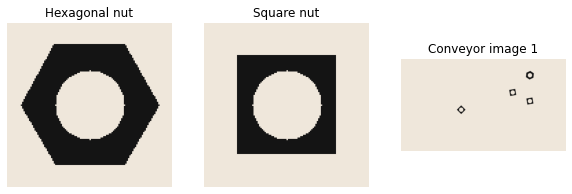

In [111]:
hexnut_template = cv.imread('hexnut_template.png', cv.IMREAD_COLOR)
squarenut_template = cv.imread('squarenut_template.png', cv.IMREAD_COLOR)
conveyor_f100 = cv.imread('conveyor_f100.png', cv.IMREAD_COLOR)

hexnut_template = cv.cvtColor(hexnut_template, cv.COLOR_BGR2RGB)
squarenut_template = cv.cvtColor(squarenut_template, cv.COLOR_BGR2RGB)
conveyor_f100 = cv.cvtColor(conveyor_f100, cv.COLOR_BGR2RGB)

fig, ax = plt. subplots(1,3, figsize=(10, 10))
ax[0].imshow(hexnut_template)
ax[0].set_title("Hexagonal nut")
ax[0].axis("off")
ax[1].imshow(squarenut_template)
ax[1].set_title("Square nut")
ax[1].axis("off")
ax[2].imshow(conveyor_f100)
ax[2].set_title("Conveyor image 1")
ax[2].axis("off")
plt.show()


##### Thresholding with otsu algorithm 

In [112]:
hexnut_template_gray = cv.cvtColor(hexnut_template, cv.COLOR_RGB2GRAY)
squarenut_template_gray = cv.cvtColor(squarenut_template, cv.COLOR_RGB2GRAY)
conveyor_f100_gray = cv.cvtColor(conveyor_f100, cv.COLOR_RGB2GRAY)

ret0,hexnut_template_gray = cv.threshold(hexnut_template_gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
ret1,squarenut_template_gray = cv.threshold(squarenut_template_gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
ret2,conveyor_f100_gray = cv.threshold(conveyor_f100_gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

print("Threshold for hexagonal nut template:", ret0)
print("Threshold for square nut template:", ret1)
print("Threshold for conveyor:", ret2)

Threshold for hexagonal nut template: 20.0
Threshold for square nut template: 20.0
Threshold for conveyor: 20.0


##### Marphological closing

In [113]:
kernel = np.ones((3,3), np.uint8)

hexnut_template_gray = cv.morphologyEx(hexnut_template_gray, cv.MORPH_CLOSE, kernel)
squarenut_template_gray = cv.morphologyEx(squarenut_template_gray, cv.MORPH_CLOSE, kernel)
conveyor_f100_gray = cv.morphologyEx(conveyor_f100_gray, cv.MORPH_CLOSE, kernel)

In [114]:
def create_table(retval, stats, centroids):
    if retval == 2: print("Only a single component is detected")
    else: print("There are", retval-1, "components are detected excluding the background.")

    table = {
                'Name': ["Component" + str(i) for i in range(1, retval)],
                "X coordinate": stats[1:, 0],
                "Y coordinate": stats[1:, 1],
                "Length in X direction": stats[1:, 2],
                "Length in y direction": stats[1:, 3],
                "Area": stats[1:, 4],
                "Centroid": ["({}, {})".format(round(center[0], 3), round(center[1], 3)) for center in centroids[1:]]
            }
    df = pd.DataFrame(table)     
    return df

##### Connected component analysis for hexagonal nut

In [115]:
retval, labels, stats, centroids = cv.connectedComponentsWithStats(hexnut_template_gray)
colormapped = cv.applyColorMap((labels/np.amax(labels)*255).astype('uint8'), cv.COLORMAP_PARULA)

create_table(retval, stats, centroids)

Only a single component is detected


,Name,X coordinate,Y coordinate,Length in X direction,Length in y direction,Area,Centroid
0,Component1,10,16,101,88,4728,"(59.834, 59.224)"


##### Connected component analysis for square nut

In [116]:
retval, labels, stats, centroids = cv.connectedComponentsWithStats(squarenut_template_gray)
colormapped = cv.applyColorMap((labels/np.amax(labels)*255).astype('uint8'), cv.COLORMAP_PARULA)

create_table(retval, stats, centroids)

Only a single component is detected


,Name,X coordinate,Y coordinate,Length in X direction,Length in y direction,Area,Centroid
0,Component1,24,24,72,72,3227,"(59.197, 59.197)"


##### Connected component analysis for conveyor image 1

In [117]:
retval, labels, stats, centroids = cv.connectedComponentsWithStats(conveyor_f100_gray)
colormapped = cv.applyColorMap((labels/np.amax(labels)*255).astype('uint8'), cv.COLORMAP_PARULA)

create_table(retval, stats, centroids)

There are 4 components are detected excluding the background.


,Name,X coordinate,Y coordinate,Length in X direction,Length in y direction,Area,Centroid
0,Component1,1454,150,92,100,4636,"(1499.242, 199.285)"
1,Component2,1259,359,82,82,3087,"(1299.183, 399.183)"
2,Component3,1459,459,82,82,3087,"(1499.183, 499.183)"
3,Component4,650,550,101,101,3144,"(700.0, 600.0)"


##### Contour detection

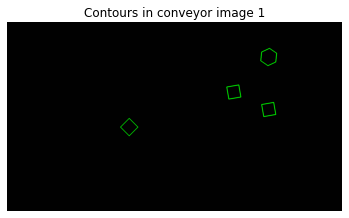

In [118]:
conveyor_f100_shape = np.ones_like(conveyor_f100)

conveyor_f100_contours, hierarchy = cv.findContours(conveyor_f100_gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(conveyor_f100_shape, conveyor_f100_contours, -1, (0,255,0), 3)

plt.imshow(conveyor_f100_shape)
plt.title("Contours in conveyor image 1")
plt.axis('off')
plt.show()

### Detecting Objects on a Synthetic Conveyor

In [119]:
hexnut_template_contours, hierarchy = cv.findContours(hexnut_template_gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
hexnut_template_contours = hexnut_template_contours[0]
squarenut_template_contours, hierarchy = cv.findContours(squarenut_template_gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
squarenut_template_contours = squarenut_template_contours[0]

In [120]:
hexnuts, squarenuts = [], []
thres = 1/1000

for index, contour in enumerate(conveyor_f100_contours):
    score = cv.matchShapes(squarenut_template_contours,contour,1,0.0)
    if score < thres: squarenuts.append(index)

    score = cv.matchShapes(hexnut_template_contours,contour,1,0.0)
    if score < thres: hexnuts.append(index)


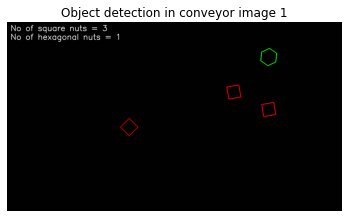

In [121]:
conveyor_f100_shape = np.ones_like(conveyor_f100)

for index in hexnuts:
    cv.drawContours(conveyor_f100_shape, conveyor_f100_contours, index, (0, 255, 0), 3)

for index in squarenuts:
    cv.drawContours(conveyor_f100_shape, conveyor_f100_contours, index, (255, 0 ,0), 3)

cv.putText(conveyor_f100_shape, "No of square nuts = {}".format(len(squarenuts)), (20, 50), cv.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv.LINE_AA)
cv.putText(conveyor_f100_shape, "No of hexagonal nuts = {}".format(len(hexnuts)), (20, 100), cv.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv.LINE_AA)

plt.imshow(conveyor_f100_shape)
plt.title("Object detection in conveyor image 1")
plt.axis('off')
plt.show()